# Overview and Background:

The Center for Medicare and Medicaid Services (CMS) has placed an emphasis on reducing 30-day readmissions with its Hospital Readmissions Reduction Program (HRRP). There are two main complications associated with these premature discharges that result in readmissions. First, there is the health concern that if patients are readmitting within 30 days, they were most likely not well enough to be discharged in the first place. Second, there are also significant financial penalties on the hospitals for having frequent 30-day readmissions. The HRRP lowers payments to Inpatient Prospective Payment System (IPPS) hospitals with too many readmissions, and also readmissions cause unnecessary waste of space in the hospitals.

Therefore, a potential solution to his task could be to use the data from the MIMIC-III dataset to create a machine learning model that can predict whether a patient will readmit within 30-days. Some considerations to take into account are that the model must be trained in a way to predict unplanned readmissions back to the hospital and that the model must have the power to predict the readmission before the patient leaves. In navigating approaches to this task, interesting work that had previously been done regarding this topic was found from a user's github: https://github.com/andrewwlong/odsc_workshop. Building off this foundation, I simulated a prediction algorithm based on Natural Language Processing (using logistic regression) that uses patient discharge summaries to predict unplanned 30-day readmissions. While the data used in this project are the discharge summaries, which supposedly are given when the patient leaves, we believe similar status reports during the patient's stay (every couple days or whenever deemed necessary) by the clinicians can be used as a substitute to produce parallel predictive powers.

# DATA:

# Used Data-set

- ADMISSIONS.csv - admission and discharge dates (identifier HADM_ID for each admission)
- NOTEEVENTS.csv - contains all discharge notes for each admission (identifier HADM_ID for each admission)

Inspired and built off of Readmission prediction modelling through Natural Language Processing from github code: https://github.com/andrewwlong/odsc_workshop

Overall, the two separate datasets (Admissions.csv and Noteevents.csv) were individually cleaned and sorted to contain information on 30-day readmission and discharge summaries, and then they were merged together using the Subject_ID and HADM_ID. Specific details are shown in the procedures below.

# Step 1. Prepare data

## ADMISSIONS.csv Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_adm = pd.read_csv('./ADMISSIONS.csv')

In [2]:
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [3]:
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [4]:
# convert to string dates to date format
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [5]:
# sort by subject_ID and admit date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [6]:
df_adm

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1
5,6,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
6,7,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,8,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NaN,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1
8,9,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,UNOBTAINABLE,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NEWBORN,0,1
9,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,NaN,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1


In [7]:
# verify that it's sorted correctly for a random patient 124
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE
168,124,2165-12-31 18:55:00,EMERGENCY


In [8]:
# get each patient's next admit date with shift() since dates are in order
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [9]:
# verify
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [10]:
# filter out next_admissions that are 'elective' so that the model predicts unsuspected/spontaneous readmissions
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [11]:
# verify
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [12]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
# backfill removed values
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])\
                            [['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [13]:
# verify that elective readmissions are extinguished from dataset
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [14]:
# calculate # of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

In [15]:
# verify
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE','DAYS_NEXT_ADMIT']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY,519.520139
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY,1468.138889
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY,208.121528
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN,NaN


# Exploratory Data Analysis:

Visualize the data and get breakdowns of the relative proportions of 30-Day Readmission Frequencies compared to the entire data sample size.
* Further data visualizations are also done in the MIMIC_TrainingandResults.ipynb notebook.

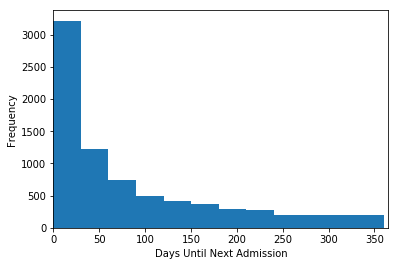

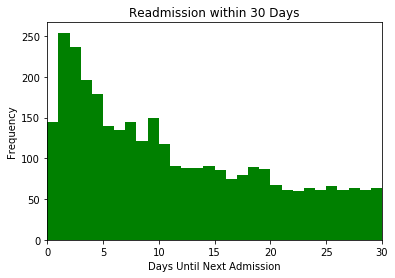

Number of total readmissions: 11399
Total number: 58976
Percentage of Total Readmissions: 19.328201302224635 %

Number with readmission < 30 days: 3227
Total Number: 58976
Percentage of <30 Day Readmissions: 5.471717308735757 %


In [16]:
# plot histogram of days until next admission
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days Until Next Admission')
plt.ylabel('Frequency')
plt.show()

# plot histogram of <30 days until next admission
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins = 30, range = (0,30), color = "green")
plt.xlim([0,30])
plt.xlabel("Days Until Next Admission")
plt.ylabel("Frequency")
plt.title("Readmission within 30 Days")
plt.show()

print("Number of total readmissions:", (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print("Total number:",len(df_adm))
print('Percentage of Total Readmissions:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum()/len(df_adm)*100,'%\n')

print('Number with readmission < 30 days:', ((~df_adm.DAYS_NEXT_ADMIT.isnull()) & (df_adm.DAYS_NEXT_ADMIT <= 30.0)).sum())
print('Total Number:', len(df_adm))
print('Percentage of <30 Day Readmissions:', ((~df_adm.DAYS_NEXT_ADMIT.isnull()) & (df_adm.DAYS_NEXT_ADMIT <= 30.0)).sum()/len(df_adm)*100,'%')

In [17]:
df_adm['DAYS_NEXT_ADMIT'].dtype

dtype('float64')

## NOTEEVENTS.csv Processing

In [18]:
df_notes = pd.read_csv("./NOTEEVENTS.csv")

C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# check number of notes (multiple per admission)
len(df_notes)

2083180

In [20]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [21]:
df_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [22]:
# print random note
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [23]:
# include only discharge summaries (most data available and an aggregate report on patient's status)
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [24]:
# sort by subject_ID and HADM_ID & just get last discharge note per admission (if there are multiple discharge summaries)
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()

In [25]:
df_notes_dis_sum_last.head()

,SUBJECT_ID,HADM_ID,ROW_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,3,145834.0,44005,2101-10-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...
1,4,185777.0,4788,2191-03-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2191-3-16**] Discharge...
2,6,107064.0,20825,2175-06-15,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2175-5-30**] Dischar...
3,9,150750.0,57115,2149-11-14,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 10050**], [**Known fi..."
4,10,184167.0,17390,2103-07-06,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2103-6-28**] Dischar...


## Merge the two datasets (READMISSION & DISCHARGE SUMMARIES)

In [26]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT',\
                                'NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')

In [27]:
# check percentages of Admission Types in notes
df_adm_notes.groupby('ADMISSION_TYPE').apply(\
                lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [28]:
# remove NEWBORN admission_type data
df_adm_notes_final = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [29]:
print('Percentage of Notes Missing:', df_adm_notes_final.TEXT.isnull().sum() / len(df_adm_notes_final))

Percentage of Notes Missing: 0.03971592354195606


Save cleaned-up dataframe file

In [30]:
# verify
df_adm_notes_final

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaN,NaT,EMERGENCY,2149-11-14 10:15:00,"Name: [**Known lastname 10050**], [**Known fi..."
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2178-4-16**] ...
10,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,NaN,NaT,ELECTIVE,2104-08-20 02:57:00,Admission Date: [**2104-8-7**] Discharge ...
11,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,NaT,EMERGENCY,NaT,"Name: [**Known lastname 9900**], [**Known fir..."
13,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,128.920833,2135-05-09 14:11:00,ELECTIVE,NaT,Admission Date: [**2134-12-27**] ...
14,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2135-5-9**] D...
15,18,188822,2167-10-02 11:18:00,2167-10-04 16:15:00,NaN,NaT,EMERGENCY,NaT,"Name: [**Known lastname 4919**] JR,[**Known f..."


In [31]:
df_adm_notes_final.to_csv('df_adm_notes_final.csv')